In [1]:
import numpy as np
import pandas as pd

# Load the CSV file, ignoring dtype warnings by setting low_memory=False
df = pd.read_csv('position_velocity_data.csv', low_memory=False)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

# Convert them to numpy arrays
positions = [df[col].astype(float).values for col in position_cols]
velocities = [df[col].astype(float).values for col in velocity_cols]

# Optionally, convert to numpy arrays with shape (num_traces, num_points)
positions = np.array(positions)
velocities = np.array(velocities)

# Print the shapes to verify
print(f"Positions shape: {positions.shape}")
print(f"Velocities shape: {velocities.shape}")


Positions shape: (3, 148148)
Velocities shape: (3, 148148)


zero idx: [ 10687  27664  55450  75486  84675  92178  93747 124720]
zero idx: [ 1936  7832  8199 23640 27329 47597 48738 90344]
zero idx: [19844 33337 42499 46511 48230 57027 87836]


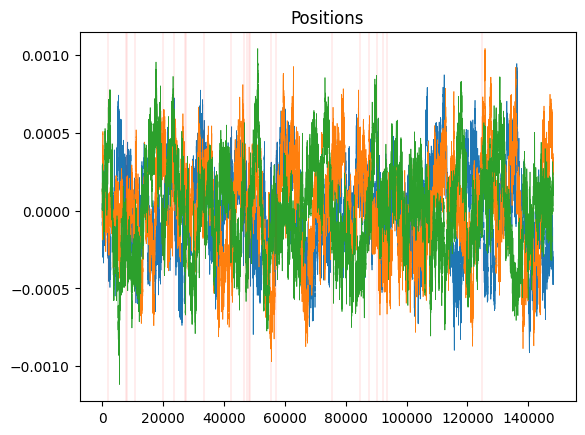

In [2]:
# Find spots where velocity is zero
import matplotlib.pyplot as plt

index_mult = 1#(timestep * sample_rate) * tao_c
x_c = 1

zero_idxs = []
for i in range(len(velocities)):
    # plt.plot([t * index_mult for t in range(len(positions[i]))], positions[i] * x_c, linewidth=0.5)
    plt.plot([t * index_mult for t in range(len(velocities[i]))], velocities[i], linewidth=0.5)
    tolerance = (.00005*np.std(velocities[i]))
    close_to_zero_indices = np.where(abs(velocities[i]) < tolerance)[0]
    print("zero idx: " + str(close_to_zero_indices))
    plt.title("Positions")
    # Draw vertical lines where values are close to zero
    for index in close_to_zero_indices:
        plt.axvline(x=index*index_mult, color='red', linestyle='-', linewidth=0.1)
        
    zero_idxs.append(close_to_zero_indices)

In [3]:
from tqdm import tqdm
def compute_msd(time_trace, dt):
    """
    Compute the Mean Squared Displacement (MSD) for a 1D time trace.

    Parameters:
        time_trace (numpy.ndarray): 1D array of position values.
        dt (float): Time interval between consecutive points in the time trace.

    Returns:
        numpy.ndarray: Array of MSD values for each lag time.
        numpy.ndarray: Array of corresponding lag times.
    """
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

100%|██████████| 10000/10000 [00:00<00:00, 181123.11it/s]


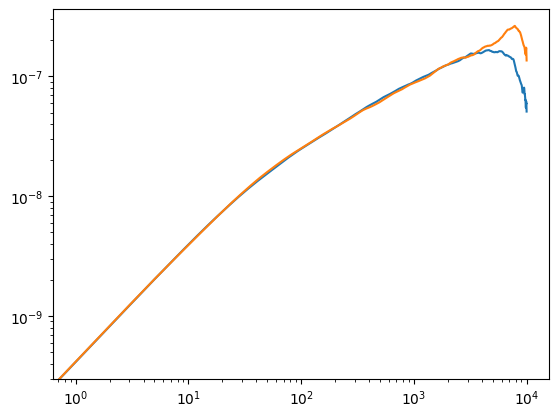

In [8]:
msd_len = 10000
sampling_rate = 1
msds = []
lag_times = 0

for i in range(len(velocities)):
    for idx in zero_idxs[i]:
        super_trace = velocities[i][idx:idx+msd_len]
        msd, lag_times = compute_msd(super_trace, sampling_rate)
        msds.append(msd)
        
msds2 = []
for i in range(len(velocities)):
    for idx in zero_idxs[i]:
        idx = idx+10000
        trace = velocities[i][idx:idx+msd_len]
        msd2, lag_times = compute_msd(trace, sampling_rate)
        msds2.append(msd2)
        
mean_msd = np.mean(msds, axis=0)
mean_msd2 = np.mean(msds2, axis=0)

plt.plot(lag_times, mean_msd)
plt.plot(lag_times, mean_msd2)
plt.xscale('log')
plt.yscale('log')
        